In [1]:
from jitcdde import jitcdde, t
from toyParameters import *
import numpy as np
from msrDynamics.objects import Node, System
import matplotlib.pyplot as plt

Instantiate System Object & Nodes

In [2]:
# MSR system        
MSR = System()

# core nodes
cf_in = Node(m = m_f_c/2, scp = scp_f, W = W_f, y0 = T0_c_f1)  # core fuel inlet
cf_out = Node(m = m_f_c/2, scp = scp_f, W = W_f, y0 = T0_c_f2) # core fuel outlet
cm = Node(m = m_m_c, scp = scp_m, y0 = 1005.8056360691721)                 # core moderator

n = Node(y0 = n_frac0)     # fractional neutron density
C1 = Node(y0 = C0[0])      # precursor group 1
C2 = Node(y0 = C0[1])      # precursor group 2
C3 = Node(y0 = C0[2])      # precursor group 3
C4 = Node(y0 = C0[3])      # precursor group 4
C5 = Node(y0 = C0[4])      # precursor group 5
C6 = Node(y0 = C0[5])      # precursor group 6
rho = Node(y0 = 0.0)       # reactivity

# heat exchanger nodes 
hx_p_in = Node(m = m_f_hx, scp = scp_f, W = W_f, y0 = T0_hfh_f1)     # hx primary circuit inlet
hx_p_out = Node(m = m_f_hx, scp = scp_f, W = W_f, y0 = T0_hfh_f2)    # hx primary circuit outlet
hx_t = Node(m = m_t_hxfh, scp = scp_t, y0 = T0_hfh_t1)                   # hx tubes
hx_s_in = Node(m = m_h_hxfh, scp = scp_h, W = W_h_fh, y0 = T0_hfh_h1)  # hx secondary circuit inlet
hx_s_out = Node(m = m_h_hxfh, scp = scp_h, W = W_h_fh, y0 = T0_hfh_h2) # hx secondary circuit outlet

# populate system 
MSR.addNodes([cf_in,cf_out,cm,n,C1,C2,C3,C4,C5,C6,rho,
              hx_p_in,hx_p_out,hx_t,hx_s_in,hx_s_out])

Define Dynamics

In [3]:
# core
cf_in.set_dTdt_bulkFlow(source = hx_p_out.y()) 
cf_in.set_dTdt_internal(source = n.y(), k = k_f1*P/mcp_f_c)
cf_in.set_dTdt_convective(source = [cm.y()], hA = [hA_ft_c/2])

cf_out.set_dTdt_bulkFlow(source = cf_in.y()) 
cf_out.set_dTdt_internal(source = n.y(), k = k_f2*P/mcp_f_c)
cf_out.set_dTdt_convective(source = [cm.y()], hA = [hA_ft_c/2])

cm.set_dTdt_internal(source = n.y(), k = k_m*P/mcp_m_c)
cm.set_dTdt_convective(source = [cf_in.y(), cf_out.y()], hA = [hA_mc_c]*2)

n.set_dndt(rho.y(), beta_t, Lam, lam, [C1.y(), C2.y(), C3.y(), C4.y(), C5.y(), C6.y()])
C1.set_dcdt(n.y(), beta[0], Lam, lam[0], tau_c, tau_l)
C2.set_dcdt(n.y(), beta[1], Lam, lam[1], tau_c, tau_l)
C3.set_dcdt(n.y(), beta[2], Lam, lam[2], tau_c, tau_l)
C4.set_dcdt(n.y(), beta[3], Lam, lam[3], tau_c, tau_l)
C5.set_dcdt(n.y(), beta[4], Lam, lam[4], tau_c, tau_l)
C6.set_dcdt(n.y(), beta[5], Lam, lam[5], tau_c, tau_l)
rho.set_drdt([cf_in.dydt(),cf_out.dydt(),cm.dydt()],[a_f/2,a_f/2,a_b])

# heat exchanger
hx_p_in.set_dTdt_bulkFlow(source = cf_out.y())
hx_p_in.set_dTdt_convective(source = [hx_t.y()], hA = [hA_ft_hx])

hx_p_out.set_dTdt_bulkFlow(source = hx_p_in.y())
hx_p_out.set_dTdt_convective(source = [hx_t.y()], hA = [hA_ft_hx])

hx_t.set_dTdt_convective(source = [hx_p_in.y(),hx_p_out.y(),hx_s_in.y(),hx_s_out.y()],
                              hA = [hA_ft_hx, hA_ft_hx, hA_ht_hx, hA_ht_hx])

hx_s_in.set_dTdt_bulkFlow(source = 100)
hx_s_in.set_dTdt_convective(source = [hx_t.y()], hA = [hA_ht_hx])

hx_s_out.set_dTdt_bulkFlow(source = hx_s_in.y())
hx_s_out.set_dTdt_convective(source = [hx_t.y()], hA = [hA_ht_hx])

In [4]:

# instantiate jitcdde object
DDE = jitcdde([N.dydt() for N in MSR.nodes])

# set initial conditions
DDE.constant_past([N.y0 for N in MSR.nodes])

In [5]:
# solve
sol_jit = []
for t_x in T:
    sol_jit.append(DDE.integrate(t_x))

Generating, compiling, and loading C code.
Using default integration parameters.


/mnt/envs/thesis_env/lib/python3.9/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/mnt/envs/thesis_env/lib/python3.9/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle in

(0.0, 100.0)

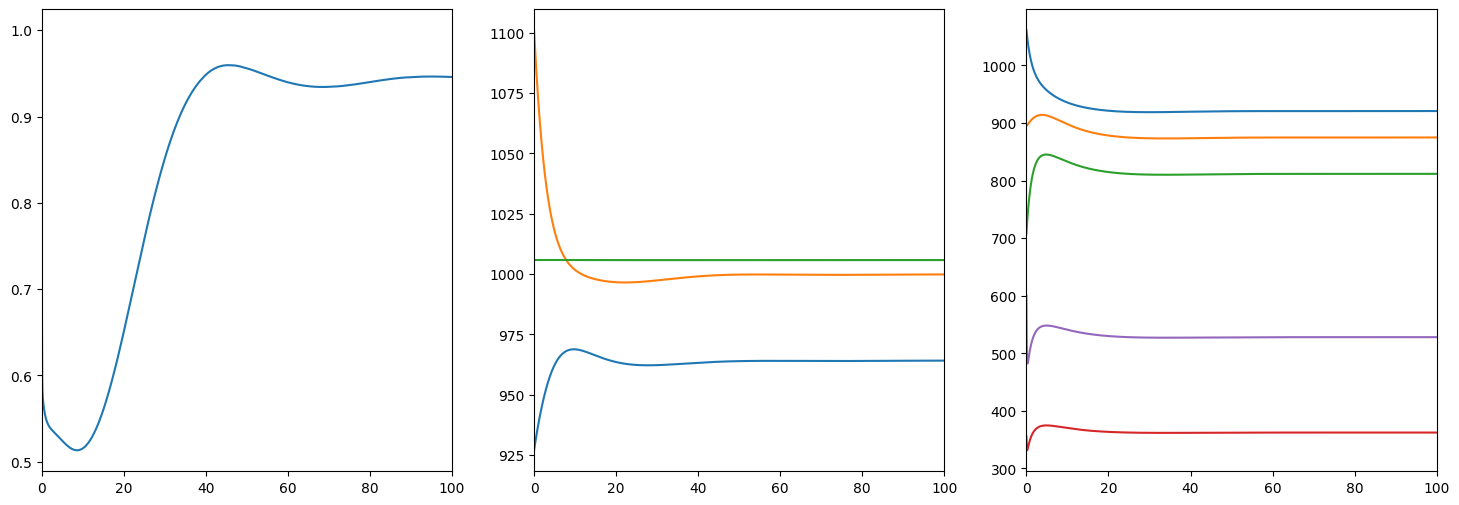

In [8]:
fig,axs = plt.subplots(1,3,figsize=(18,6))

t0 = 0.0
tf = 150.00

# P
axs[0].plot(T,[s[3]*P for s in sol_jit])
axs[0].set_xlim(t0,tf)

# core temps 
axs[1].plot(T,[s[0] for s in sol_jit])
axs[1].plot(T,[s[1] for s in sol_jit])
axs[1].plot(T,[s[2] for s in sol_jit])
axs[1].set_xlim(t0,tf)

# hx temps
axs[2].plot(T,[s[11] for s in sol_jit])
axs[2].plot(T,[s[12] for s in sol_jit])
axs[2].plot(T,[s[13] for s in sol_jit])
axs[2].plot(T,[s[14] for s in sol_jit])
axs[2].plot(T,[s[15] for s in sol_jit])
axs[2].set_xlim(t0,tf)

In [7]:
sol_jit[-1][2]

1006.8513597919259